# White Giant with Expander Cycle

Investigation into using a turbopump at the cooling system exit

In [34]:
#Import required modules
import bamboo as bam
import bamboo.cooling as cool
import bamboo.materials


import numpy as np
import matplotlib.pyplot as plt
import pypropep as ppp
import bamboo.plot
from CoolProp.CoolProp import PropsSI

import matplotlib as mpl

### *Engine setup*

In [35]:
'''Chamber conditions'''
pc = 10e5                   #Chamber pressure (Pa)
mdot = 5.4489               #Mass flow rate (kg/s)
p_amb = 1.01325e5           #Ambient pressure (Pa). 1.01325e5 is sea level atmospheric.
OF_ratio = 5                #Oxidiser/fuel mass ratio
water_mass_fraction = 0.0  #Fraction of the fuel that is water, by mass

'''Get combustion properties from pypropep'''
ppp.init()
e = ppp.Equilibrium()
ipa = ppp.PROPELLANTS['ISOPROPYL ALCOHOL']
water = ppp.PROPELLANTS['WATER']
n2o = ppp.PROPELLANTS['NITROUS OXIDE']

#Add propellants by mass fractions (note the mass fractions can add up to more than 1)
e.add_propellants_by_mass([(ipa, 1-water_mass_fraction), (water, water_mass_fraction), (n2o, OF_ratio)])

#Adiabatic combustion using chamber pressure                      
e.set_state(P = pc/1e5, type='HP')                      

gamma = e.properties.Isex   #pyrpopep uses 'Isex' for the ratio of specific heats
cp = 1000*e.properties.Cp   #Cp is given in kJ/kg/K, we want J/kg/K
Tc = e.properties.T

'''Set up the engine object'''
perfect_gas = bam.PerfectGas(gamma = gamma, cp = cp)    #Gas for frozen flow
chamber_conditions = bam.ChamberConditions(pc, Tc, mdot)
nozzle = bam.Nozzle.from_engine_components(perfect_gas, chamber_conditions, p_amb, type = "rao")
engine = bam.Engine(perfect_gas, chamber_conditions, nozzle)

print(f"\nNozzle throat area = {nozzle.At} m^2, nozzle exit area = {nozzle.Ae} m^2")

'''Check the thrust and specific impulse'''
print("")
print(f"Chamber Temperature: {Tc} K")
print(f"Gamma = {gamma}")
print(f"cp = {cp} J/kg/K")
print("")
print(f"Sea level thrust = {engine.thrust(1e5)/1000} kN      (using perfect gas relations)")
print(f"Sea level Isp = {engine.isp(1e5)} s         (using perfect gas relations)")



Loaded 1921 thermo species
Loaded 1031 propellants
NOTE: Area ratio is outside of data range for Rao bell nozzle graphs (minimum 3.7, maximum 47). Using a 15 deg cone nozzle instead.

Nozzle throat area = 0.010981538511554725 m^2, nozzle exit area = 0.025928421938621233 m^2

Chamber Temperature: 3086.8481884125868 K
Gamma = 1.1453747614753838
cp = 4215.9009306078415 J/kg/K

Sea level thrust = 13.993998041231935 kN      (using perfect gas relations)
Sea level Isp = 261.8860079470274 s         (using perfect gas relations)


### *Cooling simulation*

In [36]:
'''Transport properties'''
#CoolProp takes mole fractions for mixtures I believe, not mass fractions.
#Setup the exhaust gas transport properties
def Pr_gas(T, p):
    return PropsSI("PRANDTL", "T", T, "P", p, "NITROGEN")

def mu_gas(T, p):
    return PropsSI("VISCOSITY", "T", T, "P", p, "NITROGEN")

def k_gas(T, p):
    return PropsSI("CONDUCTIVITY", "T", T, "P", p, "NITROGEN")

gas_transport = bam.cooling.TransportProperties(type = "functions",
                                                Pr = Pr_gas,
                                                mu = mu_gas,
                                                k = k_gas)

#Set up the coolant transport properties
def Pr_coolant(T, p):
    try:
        return PropsSI("PRANDTL", "T", T, "P", p, "ETHANOL")
    except ValueError:
        return PropsSI("PRANDTL", "T", T, "Q", 0, "ETHANOL")

def mu_coolant(T, p):
    try:
        return PropsSI("VISCOSITY", "T", T, "P", p, "ETHANOL")
    except ValueError:
        return PropsSI("VISCOSITY", "T", T, "Q", 0, "ETHANOL")
    
def k_coolant(T, p):
    try:
        return PropsSI("CONDUCTIVITY", "T", T, "P", p, "ETHANOL")
    except ValueError:
        return PropsSI("CONDUCTIVITY", "T", T, "Q", 0, "ETHANOL")
    
def cp_coolant(T, p):
    try:
        return PropsSI("CPMASS", "T", T, "P", p, "ETHANOL")
    except ValueError:
        return PropsSI("CPMASS", "T", T, "Q", 0, "ETHANOL")
    
def rho_coolant(T, p):#
    try:
        return PropsSI("DMASS", "T", T, "P", p, "ETHANOL") 
    except ValueError:
        return PropsSI("DMASS", "T", T, "Q", 0, "ETHANOL")
    
def T_from_enthalpy(enthalpy, p):
    return PropsSI('T','H', enthalpy,'P', p, 'ETHANOL')

def enthalpy_from_T(T, p):
    return PropsSI('H','T', T, 'P', p, 'ETHANOL')

coolant_transport = bam.cooling.TransportProperties(type = "functions",
                                                    Pr = Pr_coolant,
                                                    mu = mu_coolant,
                                                    k = k_coolant,
                                                    cp = cp_coolant,
                                                    rho = rho_coolant,
                                                    T_from_enthalpy = T_from_enthalpy,
                                                    enthalpy_from_T = enthalpy_from_T)



#Add the gas transport properties to the engine
engine.add_exhaust_transport(gas_transport)

#Coolant transport properties will get used later when creating adding the CoolingJacket to the engine

Wall material properties:
bamboo.cooling.Material Object
        Young's modulus = 140.0 GPa 
        0.2% Yield Stress = 600.0 MPa 
        Poisson's ratio = 0.355
        alpha = 1.75e-05 strain/K
        Thermal conductivity = 211 W/m/K
        (may also have a specific heat capacity (self.c) and density (self.rho))

Graphite insert properties:
bamboo.cooling.Material Object
        Young's modulus = nan GPa 
        0.2% Yield Stress = nan MPa 
        Poisson's ratio = nan
        alpha = nan strain/K
        Thermal conductivity = 63.81001 W/m/K
        (may also have a specific heat capacity (self.c) and density (self.rho))



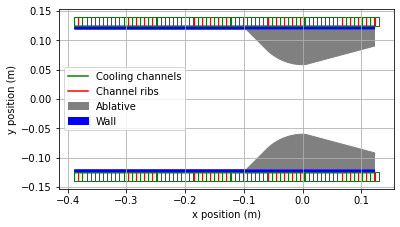

In [53]:
'''Chamber and wall geometry'''
Ac = np.pi*0.12**2                      #Chamber cross-sectional area (m^2)
inner_wall_thickness = 5e-3    #Placeholder whilst we generate the rest of the geometry
L_star = 1.2                           #L_star = Volume_c/Area_t
chamber_length = L_star*nozzle.At/Ac   #Length of the combustion chamber

engine.add_geometry(chamber_length = chamber_length,
                    chamber_area = Ac,
                    inner_wall_thickness = inner_wall_thickness)

'''Coolant jacket'''
mdot_coolant = mdot/(OF_ratio + 1)               #Coolant mass flow rate
inlet_T = 298.15                                 #Coolant inlet temperature (K)
inlet_p0 = 146e5                                  #Coolant inlet stagnation pressure (Pa)
wall_material = bam.materials.CopperC700         #Copper inner wall

#Add the cooling jacket
engine.add_cooling_jacket(wall_material, 
                          inlet_T, 
                          inlet_p0, 
                          coolant_transport, 
                          mdot_coolant, 
                          configuration = "spiral", 
                          channel_width =  14e-3,
                          channel_height = 14e-3,
                          blockage_ratio = (1/49),
                          number_of_ribs = 2)

#Add the exhaust gas transport properties
engine.add_exhaust_transport(gas_transport)

'''Graphite insert'''
ablative_material = bam.materials.Graphite
engine.add_ablative(ablative_material)

#Print the wall and ablative material properties
print("Wall material properties:")
print(wall_material)

print("\nGraphite insert properties:")
print(ablative_material)
print("")

#Plot the geometry
engine.plot_geometry()
plt.show()

In [54]:
#Run simulation
heating_data = engine.steady_heating_analysis(to_json = False, 
                                              h_gas_model = 'bartz-sigma', 
                                              h_coolant_model = 'sieder-tate',
                                              gas_fudge_factor = 1.3)

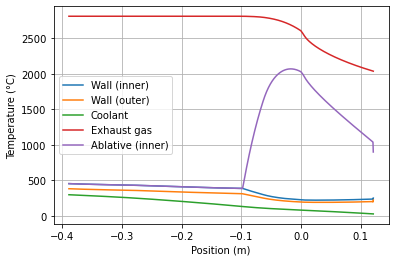

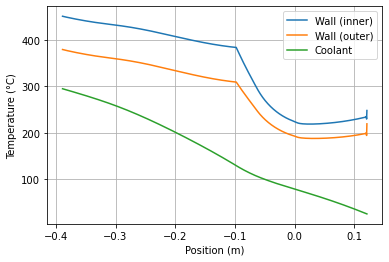

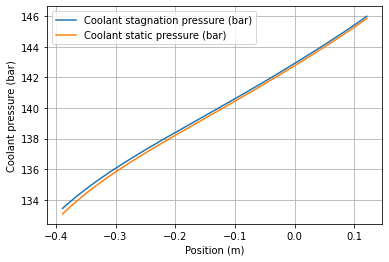

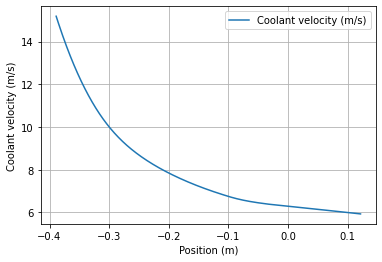

In [55]:
#Show plots
bam.plot.plot_temperatures(heating_data, show_gas = True, show_ablative = True)
bam.plot.plot_temperatures(heating_data, show_gas = False, show_ablative = False)
bam.plot.plot_jacket_pressure(heating_data)
bam.plot.plot_coolant_velocities(heating_data)

plt.show()

Check how much enthalpy we have available in the coolant

In [56]:
from CoolProp.CoolProp import PhaseSI

#Inputs
turbine_exit_p0 = 20e5
turbine_isentropic_efficiency = 0.7

compressor_inlet_p0 = 5e5
compressor_inlet_T0 = 298
compressor_isentropic_efficiency = 0.7

#TURBINE
turbine_inlet_enthalpy =  heating_data["enthalpy_coolant"][-1]
turbine_inlet_p0 = heating_data["p0_coolant"][-1]
turbine_inlet_entropy = PropsSI('S','H', turbine_inlet_enthalpy, 'P', turbine_inlet_p0, 'ETHANOL')

turbine_exit_enthalpy_isen = PropsSI('H','S', turbine_inlet_entropy, 'P', turbine_exit_p0, 'ETHANOL')
turbine_enthalpy_drop = turbine_isentropic_efficiency*(turbine_inlet_enthalpy - turbine_exit_enthalpy_isen)
turbine_exit_enthalpy = turbine_inlet_enthalpy - turbine_enthalpy_drop

print("----------TURBINE----------")
print(f"Enthalpy available = {turbine_enthalpy_drop/1e3} kJ/kg")
print("")
print(f"Inlet temperature = {PropsSI('T','H', turbine_inlet_enthalpy, 'P', turbine_inlet_p0, 'ETHANOL') - 273.15} C")
print(f"Inlet pressure = {turbine_inlet_p0/1e5} bar")
print(f"Inlet entropy = {turbine_inlet_entropy/1e3} kJ/kg/K")
print("")
print(f"Inlet phase = {PhaseSI('H', turbine_inlet_enthalpy, 'P', turbine_inlet_p0, 'ETHANOL')}")
print(f"Inlet dryness fraction (molar) = {PropsSI('Q','H', turbine_inlet_enthalpy, 'P', turbine_inlet_p0, 'ETHANOL')}") 
print("")
print(f"Exit temperature = {PropsSI('T','H', turbine_exit_enthalpy, 'P', turbine_exit_p0, 'ETHANOL') - 273.15} C")
print(f"Exit pressure = {turbine_exit_p0/1e5} bar")
print(f"Exit entropy = {PropsSI('S','H', turbine_exit_enthalpy, 'P', turbine_exit_p0, 'ETHANOL')/1e3} kJ/kg/K")
print("")
print(f"Exit phase = {PhaseSI('H', turbine_outlet_enthalpy, 'P', turbine_exit_p0, 'ETHANOL')}")
print(f"Exit dryness fraction (molar) = {PropsSI('Q','H', turbine_exit_enthalpy, 'P', turbine_exit_p0, 'ETHANOL')}")   

#COMPRESSOR
compressor_inlet_enthalpy = PropsSI('H','T', compressor_inlet_T0, 'P', compressor_inlet_p0, 'ETHANOL')
compressor_inlet_entropy = PropsSI('S','T', compressor_inlet_T0, 'P', compressor_inlet_p0, 'ETHANOL')
compressor_exit_enthalpy = compressor_inlet_enthalpy + turbine_enthalpy_drop
compressor_exit_enthalpy_isen = compressor_inlet_enthalpy + compressor_isentropic_efficiency*turbine_enthalpy_drop

#If isentropic
compressor_exit_p0 = PropsSI('P','H', compressor_exit_enthalpy_isen, 'S', compressor_inlet_entropy, 'ETHANOL')
compressor_exit_T0 = PropsSI('T','H', compressor_exit_enthalpy_isen, 'P', compressor_exit_p0, 'ETHANOL')

print("")
print("")
print("----------COMPRESSOR----------")
print(f"Inet temperature = {compressor_inlet_T0 - 273.15} C")
print(f"Inet pressure = {compressor_inlet_p0/1e5} bar")
print(f"Inlet entropy = {compressor_inlet_entropy/1e3} kJ/kg/K")
print("")
print(f"Inlet phase = {PhaseSI('T', compressor_inlet_T0, 'P', compressor_inlet_p0, 'ETHANOL')}")
print("")
print(f"Exit temperature = {compressor_exit_T0 - 273.15} C")
print(f"Exit pressure = {compressor_exit_p0/1e5} bar")
print(f"Exit entropy = {PropsSI('S','H', compressor_exit_enthalpy, 'P', compressor_exit_p0, 'ETHANOL')/1e3} kJ/kg/K")
print(f"")
print(f"Exit phase = {PhaseSI('H', compressor_exit_enthalpy, 'P', compressor_exit_p0, 'ETHANOL')}")
print(f"Exit wetness fraction = {PropsSI('Q','H', compressor_exit_enthalpy, 'P', compressor_exit_p0, 'ETHANOL')}")

----------TURBINE----------
Enthalpy available = 60.633398565452495 kJ/kg

Inlet temperature = 295.2231522886036 C
Inlet pressure = 133.43573735773464 bar
Inlet entropy = 1.9568572397293384 kJ/kg/K

Inlet phase = supercritical
Inlet dryness fraction (molar) = -1.0

Exit temperature = 180.45219374228628 C
Exit pressure = 20.0 bar
Exit entropy = 2.014144754209704 kJ/kg/K

Exit phase = twophase
Exit dryness fraction (molar) = 0.8668359159106462


----------COMPRESSOR----------
Inet temperature = 24.850000000000023 C
Inet pressure = 5.0 bar
Inlet entropy = -0.4408113251877051 kJ/kg/K

Inlet phase = liquid

Exit temperature = 30.052628000336085 C
Exit pressure = 343.3628182559419 bar
Exit entropy = -0.38153969922751496 kJ/kg/K

Exit phase = supercritical_liquid
Exit wetness fraction = -1.0


In [57]:
'''
import CoolProp
from CoolProp.Plots import PropertyPlot
plot = PropertyPlot('ETHANOL', 'TS')
plot.calc_isolines(CoolProp.iQ)
plot.calc_isolines(CoolProp.iP)
plot.show()
'''

"\nimport CoolProp\nfrom CoolProp.Plots import PropertyPlot\nplot = PropertyPlot('ETHANOL', 'TS')\nplot.calc_isolines(CoolProp.iQ)\nplot.calc_isolines(CoolProp.iP)\nplot.show()\n"